# Workflows and Agents

There is a lot of confusion about what exactly an ai agent is and the differnce between an llm workflow and an agent. Luckily this blog post from [Anthropic](https://www.anthropic.com/engineering/building-effective-agents) goes into a lot of detail. Today we will explore the different types of workflows and agents using a practical example for each:

All augmented LLMs cloud be considered an agent. As long as there is some dynamic interaction from the LLM with the environment. For example, writing to a file, executing a command or reading an error message. However Anthorpic has a more strict definition, drawing a distinction between workflows and agents:

- **Workflows** are systems where LLMs and tools are orchestrated through predefined code paths.
- **Agents**, on the other hand, are systems where LLMs dynamically direct their own processes and tool usage, maintaining control over how they accomplish tasks.

So workflows give you more rigid deterministic control over the process, while agents are more flexible and can adapt to the situation at hand. Often the simplest solution is the best, and that might mean, even though agents is the buzzword of the week, using a workflow in many cases.
> Agentic systems often trade latency and cost for better task performance, and you should consider when this tradeoff makes sense.

## Prompt chaining
A simple workflow that pipes the output of one prompt as input to another prompt. It can even have some arbitrary logic to gate between the prompts. 



In [ ]:
!pip install langgraph

In [13]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

load_dotenv()
llm = ChatOpenAI(model="gpt-4.1-mini")

In [36]:
from typing_extensions import TypedDict

# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    shortened_joke: str


def generate_joke(state: State):
    """Generates inital Joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier, only print the joke: {state['joke']}")
    return {"improved_joke": msg.content}


def shorten_joke(state: State):
    """Third LLM call to shorten the joke"""

    msg = llm.invoke(f"Make this joke shorter: {state['improved_joke']}")
    return {"shortened_joke": msg.content}


def check_length(state: State):
    """Gate function to check if the joke is too long"""

    # Check if the joke is too long
    if  len(state["improved_joke"].split()) > 20:
        return  "too long"
    return "pass"


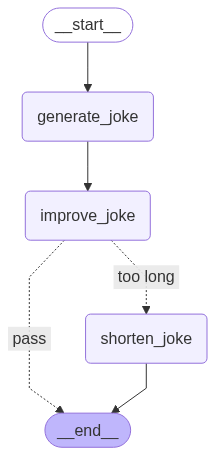

In [37]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


workflow = StateGraph(State)

workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("shorten_joke", shorten_joke)

workflow.add_edge(START, "generate_joke")
workflow.add_edge("generate_joke", "improve_joke")
workflow.add_conditional_edges(
    "improve_joke", check_length, {"pass": END, "too long": "shorten_joke"}
)
workflow.add_edge("shorten_joke", END)

chain = workflow.compile()

display(Image(chain.get_graph().draw_mermaid_png()))

In [38]:
def print_state(state):
    print("Initial joke:")
    print(state["joke"])
    print("\n--- --- ---\n")
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")
    if "shortened_joke" in state:
        print("Final joke:")
        print(state["shortened_joke"])
    else:
        print("Joke already short enought!")
        

state = chain.invoke({"topic": "cats"})
print_state(state)

Initial joke:
Why did the cat sit on the computer?  
Because it wanted to keep an eye on the mouse!

--- --- ---

Improved joke:
Why did the cat sit on the computer?  
Because it heard the mouse was in there, and it didn’t want to be left out of the click party!

--- --- ---

Final joke:
Why did the cat sit on the computer?  
It heard the mouse was in there!


## Routing

The idea between routing is selecting a specialized model for a specific task. This can be done by using a routing function that selects the model based on the input. The routing function can be as simple or complex as needed.

If the task does not require a lot of resources, it might be a smaller model. Or maybe it redirects to a whole different agent that can retrieve information from a list of documents.

In [92]:
from typing_extensions import Literal
from pydantic import BaseModel, Field

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["general", "physics", "math"] = Field(
        None, description="The difficulty of the request"
    )

# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

In [93]:
from langchain_core.messages import HumanMessage, SystemMessage

class State(TypedDict):
    input: str
    decision: str
    output: str

physics_llm = ChatOpenAI(model="gpt-4.1-nano")
math_llm = ChatOpenAI(model="gpt-4.1-nano")

# Nodes
def call_physics_llm(state: State):
    result = physics_llm.invoke(state["input"])
    return {"output": result.content}

def call_math_llm(state: State):
    result = math_llm.invoke(state["input"])
    return {"output": result.content}

def call_general_llm(state: State):
    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the based on what knowledge is required to answer!"
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}

# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "physics":
        return "physics_llm"
    elif state["decision"] == "math":
        return "math_llm"
    else:
        return "general_llm"

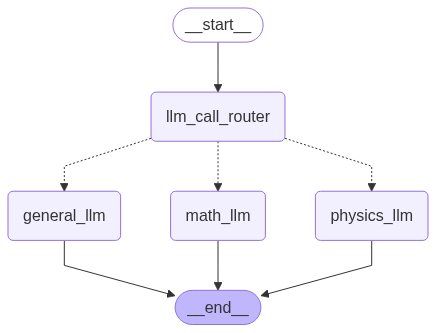

In [94]:
# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_router", llm_call_router)

router_builder.add_node("physics_llm", call_physics_llm)
router_builder.add_node("math_llm", call_math_llm)
router_builder.add_node("general_llm", call_general_llm)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")

router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {
        "physics_llm":"physics_llm",
         "math_llm" :"math_llm",
         "general_llm":"general_llm", 
    }
)
router_builder.add_edge("physics_llm", END)
router_builder.add_edge("math_llm", END)
router_builder.add_edge("general_llm", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [95]:
def print_state(state):
    print("intput:" ,state["input"])
    print("llm called:", state["decision"])
    print("output:", state["output"])
    
state = router_workflow.invoke({"input": "hi how are you?"})
print_state(state)

intput: hi how are you?
llm called: general
output: Hello! I'm doing great, thank you. How can I assist you today?


In [96]:
state = router_workflow.invoke({"input": "compute the square root of 365"})
print_state(state)

intput: compute the square root of 365
llm called: math
output: The square root of 365 is approximately 19.104.


In [97]:
state = router_workflow.invoke({"input": "explain quantum physics in one sentence"})
print_state(state)

intput: explain quantum physics in one sentence
llm called: physics
output: Quantum physics is the branch of science that studies the behavior of matter and energy at very small scales, where particles exhibit wave-like properties and are described by probabilistic states rather than definite positions or velocities.
